In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import sympy as sm
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime 

In [2]:
Ticker1 = "GLD"
Ticker2 = "GDX"
start ="2018-01-01" 
end= datetime.today().strftime('%Y-%m-%d')
y1 = yf.download(Ticker1, start, end, interval="1d")["Adj Close"]
y2 = yf.download(Ticker2, start, end, interval="1d")["Adj Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
print(Ticker1)
print(y1)


GLD
Date
2018-01-02    125.150002
2018-01-03    124.820000
2018-01-04    125.459999
2018-01-05    125.330002
2018-01-08    125.309998
                 ...    
2023-09-13    177.080002
2023-09-14    177.169998
2023-09-15    178.339996
2023-09-18    179.389999
2023-09-19    179.220001
Name: Adj Close, Length: 1438, dtype: float64


In [4]:
print(Ticker2)
print(y2)


GDX
Date
2018-01-02    22.620510
2018-01-03    22.383101
2018-01-04    22.525545
2018-01-05    22.478064
2018-01-08    22.240650
                ...    
2023-09-13    28.719999
2023-09-14    29.110001
2023-09-15    29.719999
2023-09-18    29.750000
2023-09-19    29.400000
Name: Adj Close, Length: 1438, dtype: float64


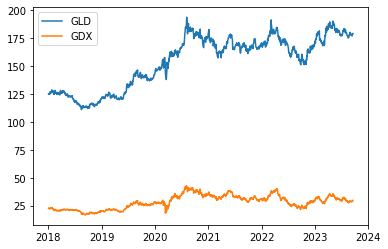

In [5]:
plt.plot(y1, label = Ticker1)
plt.plot(y2, label = Ticker2)
plt.legend()
plt.show()

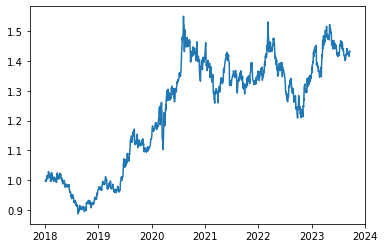

In [6]:
plt.plot((1+y1.pct_change()).cumprod())

# Analyzing stationarity of the pairs spread 

In [7]:
'''
We construct a spread between these two securities using 
linear regression and carry out a test for stationarity only on the first 5 years of data
to avoid look-ahead bias when deciding if we will trade this pair.
'''
y1_train=y1[:datetime(2022,12,31)]
y2_train=y2[:datetime(2022,12,31)]
X = sm.add_constant(y2_train)
model = sm.OLS(y1_train,X)
model = model.fit()
beta = model.params[1]
print(model.params[1])
model.params

3.2877074664839108


C:\Users\Prishal\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const        59.382792
Adj Close     3.287707
dtype: float64

In [8]:
spread = y1-y2*model.params[1]

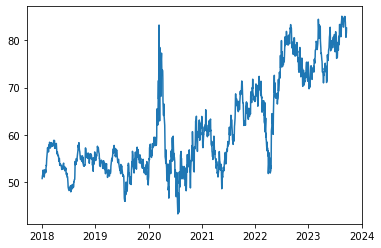

In [9]:
plt.plot(spread)
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller as adf
print(adf(spread[:1007]))
print(adf(spread[:1007])[0])
adf(spread[:1007])[4]

(-3.115916116809538, 0.025397527623721102, 7, 999, {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}, 3503.6436053990533)
-3.115916116809538


{'1%': -3.4369127451400474,
 '5%': -2.864437475834273,
 '10%': -2.568312754566378}

# Dynamic Hedge Ratio


# Rolling Regression

In [11]:
from statsmodels.regression.rolling import RollingOLS

In [12]:
window = 20

In [13]:
X = sm.add_constant(y2)
roll_mod= RollingOLS(y1,X,window)
roll_mod = roll_mod.fit()

C:\Users\Prishal\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [14]:
dynamic_beta = roll_mod.params["Adj Close"]
dynamic_beta

Date
2018-01-02         NaN
2018-01-03         NaN
2018-01-04         NaN
2018-01-05         NaN
2018-01-08         NaN
                ...   
2023-09-13    2.405519
2023-09-14    2.192347
2023-09-15    1.829518
2023-09-18    1.658515
2023-09-19    1.528077
Name: Adj Close, Length: 1438, dtype: float64

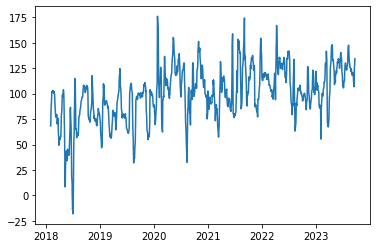

In [15]:

spread2= y1-y2*dynamic_beta

plt.plot(spread2)

In [16]:
'''
Carrying Out an ADF test on the training data to test for stationarity for the spread 
with a dynamic hedge ratio
'''
spread2_train=spread2[:datetime(2022,12,31)].dropna()
print("The ADF test statistic is "+str(adf(spread2_train)[0]))
print("The significance values are:")
print(adf(spread2_train)[4])


The ADF test statistic is -3.8587373743306768
The significance values are:
{'1%': -3.435716995109265, '5%': -2.8639100200710828, '10%': -2.568031835031368}


# Creating the Signal

In [17]:
#Bollinger Band signal for the Rolling Regression
def Signal_BB(data):
    spreads = data
    signal = []
    rolling_mean = spreads.rolling(window).mean()
    rolling_std = spreads.rolling(window).std()
    for i in range(window):
        signal.append(0)
    for i in range(window,len(spreads)):
        if (spreads[i] > rolling_mean[i]+3*rolling_std[i])or (spreads[i] < rolling_mean[i]-3*rolling_std[i]):
             signal.append(0)
        elif (spreads[i] > rolling_mean[i]+2*rolling_std[i]):
                signal.append(-1)
        
        elif spreads[i] < rolling_mean[i]-2*rolling_std[i]:
             signal.append(1)
            
        elif (spreads[i-1]<=rolling_mean[i] and spreads[i]>=rolling_mean[i])or(spreads[i-1]>=rolling_mean[i] and spreads[i]<=rolling_mean[i]):              #(spreads[i] <=  rolling_mean[i]+rolling_std[i]) and (spreads[i] >=  rolling_mean[i]-rolling_std[i]):
             signal.append(0)
        
        else:
             signal.append(signal[i-1])
        
            
        
    return signal

# Backtesting

In [18]:
def Backtester(signals, spread):
    pnl= spread.diff()
    pnl_strat = np.zeros(len(pnl))
    for i in range(1,len(pnl)):
        pnl_strat[i] = pnl[i]*signals[i-1]
        
    return pnl_strat
    

In [19]:
#Getting prices at the open which we use as inputs
y1_open = yf.download(Ticker1, start, end, interval="1d")["Open"]
y2_open = yf.download(Ticker2, start, end, interval="1d")["Open"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [20]:
'''
We compute the signals based on a day's closing prices 
and then execute the trades on the following day's opens
'''
open_spread=y1_open-dynamic_beta*y2_open
results=Backtester(Signal_BB(spread2), open_spread)

Text(0.5, 1.0, 'Daily PnL')

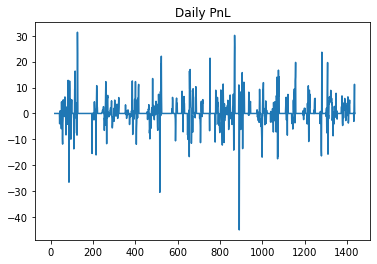

In [21]:
plt.plot(results)
plt.title("Daily PnL")

Text(0.5, 1.0, 'Total PnL')

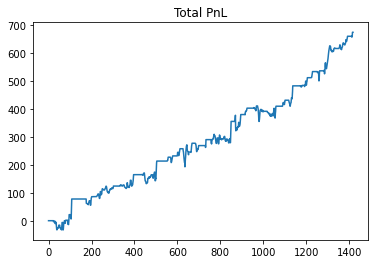

In [22]:
#Total PnL for Bollinger Band strategy
plt.plot(results[window:].cumsum())
plt.title("Total PnL")

Text(0.5, 1.0, 'Daily Gross Returns')

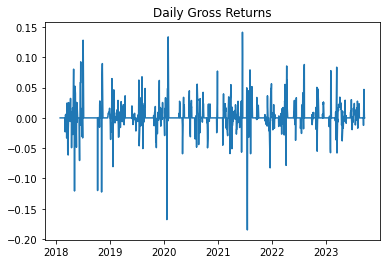

In [23]:
gross_returns=results/((y1_open+abs(dynamic_beta)*y2_open).shift(1)) #Daily PnL divided by notional value of portfolio

plt.plot(gross_returns)
plt.title("Daily Gross Returns")

Text(0.5, 1.0, 'Cumulative Gross Returns')

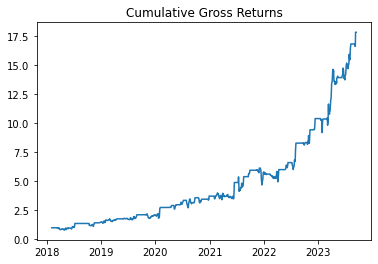

In [24]:
#Cumulative Returns
cum_returns=(1+gross_returns).cumprod()
plt.plot(cum_returns)
plt.title("Cumulative Gross Returns")


In [25]:
years=(datetime.strptime(end,"%Y-%m-%d")-datetime.strptime(start,"%Y-%m-%d")).days/365
years

5.720547945205479

In [26]:
#Compunding annual return 
CAGR = ((cum_returns[-1])**(1/years)-1)*100
print("Annual Return: "+str(round(CAGR,2))+"%")

Annual Return: 65.49%


In [27]:
#Sharpe Ratio
AnnualRate = yf.download("^TNX")["Adj Close"]
DailyRate = (1+AnnualRate/100)**(1/(365))-1

rfr = DailyRate[-1] #risk-free rate


print("Annual Sharpe Ratio: "+str(round(np.sqrt(252)*(gross_returns.mean()-rfr)/gross_returns.std(),3)))

[*********************100%***********************]  1 of 1 completed
Annual Sharpe Ratio: 1.601
